In [1]:
#Importing relevant packages 

import numpy as np
import pandas as pd
from datetime import datetime #To check start and end time when running code
from tqdm import tqdm #This is for creating progress bars.
import logging #This is to provide logging of information when running the LDA
import sys #This is to disable logging when it's no longer needed
import pickle #To store and open previously saved machine learning models 

#Importing NLTK and NLP packages
import nltk
from nltk.tokenize import TweetTokenizer
import string
import re
from collections import defaultdict

#Importing packages for data visualization 
import matplotlib.pyplot as plt
import seaborn as sns

#Importing packages for LDA
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore


# TOPIC MODELLING 

In this lab, we will apply a 50-topic LDA model to tweets from US Members of Congress to examine discussions about COVID-19 by Democrats and Republicans over time. Who was quicker to set the agenda around COVID-19, Democrats or Republicans? Make a guess if you know something about US politics.

The dataset is similar to last week's scaling lab and has been preprocessed similarly, with the main exception being that this time tweets are subsetted from 2019 and later, because we are mainly interested in tweets that (may) capture the COVID-19 crisis. The preprocessed dataset is called 'MOCTweets_preprocessed.csv'. 

#### If you wish to replicate the preprocessing, these are the steps taken for this dataset:

1. Changing 'date' from str type object to datetime type 
2. Subsetting to 2019 and later 
3. Removing unneeded columns (all except 'date', 'text', 'affiliation', and 'nominate_name')
2. Removing duplicated tweets 
7. Turning independents into Democrats or Republicans. In essence, finding the independents ("SANDERS, Bernard" and "KING, Angus Stanley, Jr.") and turning these to "Democrat". 
7. Removing instances of "&amp"
8. Replacing all remaining "&" with "and"
8. Removing odd special characters that show up in topic model ("┻","┃","━","┳","┓","┏","┛")
9. There are some annoying cases in these data where a character that looks like a space is not a space. Here, we just replace that character with an actual space. Replacing "\u202F", "\u2069", "\u200d", and "\u2066" with " ".
6. Removing "RT" and "via"
11. Removing mentions (@someone)
10. Removing numbers, removing punctuation (except hyphens and #), removing separators, removing urls, lowercasing, removing stopwords, lemmatizing, and stemming.


In [2]:
#Importing and viewing data
tweets = pd.read_csv("MOC_Tweets.csv")
tweets.head(3)

,Unnamed: 0,user_id,num_tweets,raw_url,url,url_tweet_part,tweet_type,date,tweet_id,retries,text_user_id,text,geography,affiliation,nominate_name
0,1,5558312.0,430143,none,none,none,authored,20190319,1.108000e+18,999999,5558312.0,Federal government employees are dedicated pub...,AR,Republican,"BOOZMAN, John"
1,2,5558312.0,430143,none,none,none,authored,20170803,8.929066e+17,999999,5558312.0,Congrats to @SenTomCotton's Sand Lizards on th...,AR,Republican,"BOOZMAN, John"
2,3,5558312.0,430143,https://twitter.com/60Minutes/status/656077372...,https://twitter.com/60Minutes/status/656077372...,author,quote,20151019,6.560929e+17,0,5558312.0,WATCH: I applaud Northeast #Arkansas residents...,AR,Republican,"BOOZMAN, John"


In [3]:
#Checking dataset shape
tweets.shape

(1615238, 15)

In [4]:
#Change date from str object to datetime object
tweets['date'] = pd.to_datetime(tweets['date'], format = '%Y%m%d', errors = 'ignore')


In [5]:
#Subsetting the data to span 2019 and later 
tweets = tweets.loc[tweets.date > datetime(2018,12,31)]

#Checking new dataset shape
tweets.shape


(585744, 15)

In [6]:
#Removing duplicated tweets 
tweets = tweets.drop_duplicates(subset = 'tweet_id')

#Checking new dataset shape 
tweets.shape

(579820, 15)

In [7]:
#Redefining dataset to only include useful columns 
tweets = tweets[['date','text','affiliation','nominate_name']]


In [8]:
#Locating politicians marked as 'Independent' affiliation and turning these into Democrats

print(tweets.loc[tweets.affiliation == 'Independent']['nominate_name'].value_counts())

tweets['affiliation'] = tweets['affiliation'].apply(lambda x: 'Democrat' if x == 'Independent' else x)


SANDERS, Bernard            1512
KING, Angus Stanley, Jr.     557
Name: nominate_name, dtype: int64


In [9]:
#Check if all 'Independent' were converted. Looks like it. 
print(tweets.affiliation.value_counts())

Democrat      371662
Republican    208158
Name: affiliation, dtype: int64


In [10]:
#Reusing and tweaking the function for preprocessing from last week to fit specifics of this dataset.

def preprocess(text):
    
    #Lowercasing words
    text = text.lower()
    
    #Removing '&amp' which was found to be common
    text = re.sub(r'&amp','', text)
    
    #Replace other instances of "&" with "and"
    text = re.sub(r'&','and', text)
    
    #Removing mentions 
    text = re.sub(r'@\w+ ', '', text)
    
    #Removing 'RT' and 'via'
    text = re.sub(r'(^rt|^via)((?:\b\W*@\w+)+): ', '', text)
    
    #Removing punctuation
    
    my_punctuation = string.punctuation.replace('#','')
    my_punctuation = my_punctuation.replace('-','')
    
    text = text.translate(str.maketrans('', '', my_punctuation))
    text = re.sub(r' - ','', text) #removing dash lines bounded by whitespace (and therefore not part of a word)
    text = re.sub(r'[’“”—,!]','',text) #removing punctuation that is not captured by string.punctuation
    
    #Removing odd special characters
    text = re.sub(r"[┻┃━┳┓┏┛┗]","", text)
    text = re.sub(r"\u202F|\u2069|\u200d|\u2066","", text)
    
    #Removing URLs
    text = re.sub(r'http\S+', '', text)
    
    #Removing numbers
    text = re.sub(r'[0-9]','', text)
    
    #Removing separators and superfluous whitespace
    text = text.strip()
    text = re.sub(r' +',' ',text)
    
    #Tokenizing
    tokenizer = TweetTokenizer()
    tokens = tokenizer.tokenize(text)
    
    return tokens
    

def preprocess_lemma(tokens):
    
    #Running the preprocess function
    tokens = preprocess(tokens)
    
    #Lemmatizing
    tag_map = defaultdict(lambda : nltk.corpus.wordnet.NOUN)      #POS map
    tag_map['J'] = nltk.corpus.wordnet.ADJ
    tag_map['V'] = nltk.corpus.wordnet.VERB
    tag_map['R'] = nltk.corpus.wordnet.ADV    
    
    lemmatizer = nltk.WordNetLemmatizer()             #Creating lemmatizer.
    text_lemmatized = []                              #Empty list to save lemmatized sentence

    for word, tag in nltk.pos_tag(tokens):
        lemma = lemmatizer.lemmatize(word, tag_map[tag[0]])
        text_lemmatized.append(lemma)
    
    tokens = text_lemmatized

    #Removing stopwords
    stop_words_list = nltk.corpus.stopwords.words("english")
    text = " ".join([i for i in tokens if i not in stop_words_list])
    
    return text

def preprocess_stem(tokens):
    
    #Running the preprocess function
    tokens = preprocess(tokens)
    
    #Removing stopwords
    stop_words_list = nltk.corpus.stopwords.words("english")
    tokens = [i for i in tokens if i not in stop_words_list]
    
    #Stemming
    stemmer = nltk.PorterStemmer()    #Creating stemmer
    sent_stemmed = []                 #Empty list to save stemmed sentence
    
    for word in tokens:
        stem = stemmer.stem(word)     #Stemming words
        sent_stemmed.append(stem)
        
    tokens = sent_stemmed
    
    return " ".join(tokens)


In [11]:
#Preprocessing and lemmatizing (takes approx. 10 mins)

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " Preprocessing begun.") #Printing start time

tqdm.pandas() #Getting a progress bar. Use progress_apply instead of apply.
tweets['text_lemma'] = tweets['text'].progress_apply(lambda x: preprocess_lemma(x))

print(datetime.now().strftime('%Y-%m-%d %H:%M:%S') + " Preprocessing completed.") #Printing end time


  0%|          | 0/579820 [00:00<?, ?it/s]

2021-05-02 17:03:27 Preprocessing begun.


100%|██████████| 579820/579820 [11:02<00:00, 875.48it/s] 

2021-05-02 17:14:29 Preprocessing completed.


In [12]:
#Preprocessing and stemming (takes approx. 5 mins)

tweets['text_stemmed'] = tweets['text'].progress_apply(lambda x: preprocess_stem(x))


100%|██████████| 579820/579820 [05:11<00:00, 1860.20it/s]


In [13]:
#Viewing the new dataset
tweets.head()

,date,text,affiliation,nominate_name,text_lemma,text_stemmed
0,2019-03-19,Federal government employees are dedicated pub...,Republican,"BOOZMAN, John",federal government employee dedicate public se...,feder govern employe dedic public servant prov...
7,2019-09-13,.@DeptVetAffairs recently rolled out a new dig...,Republican,"BOOZMAN, John",recently roll new digital memorial platform mi...,recent roll new digit memori platform million ...
10,2019-09-12,I know the importance of empowering women in t...,Republican,"BOOZMAN, John",know importance empower woman global economy s...,know import empow women global economi sponsor...
17,2019-03-22,It was great to spend some time with leaders i...,Republican,"BOOZMAN, John",great spend time leader van buren county talk ...,great spend time leader van buren counti talk ...
18,2019-09-18,"For 72 years, @usairforce has been blazing the...",Republican,"BOOZMAN, John",year blaze trail dominance air space cyberspac...,year blaze trail domin air space cyberspac dad...


In [14]:
#Saving the preprocessed dataset
tweets.to_csv('MOCTweets_preprocessed.csv.bz2', compression = 'bz2')

### 1: Preparing the data for topic modelling

The preprocessed data includes columns for date, affiliation, nominate name, tweet text, and two columns of preprocessed tweet text: one stemmed and one lemmatized. We will be using the stemmed text today. 

1. Import the dataframe
2. Convert 'date' from str type object to datetime type 
3. Similar to last week, replace NaN values with an empty string in the stemmed text. Then use `groupby` and `agg` to group the data by *date* and *affiliation*, and aggregate the stemmed tweet text within each of these categories into one long string. You do not need to save the nominate names. 
4. For each row, tokenize the stemmed text data into unigrams. Consider using NLTK's `TweetTokenizer`, which is made to handle e.g. hashtags and emojis.
5. For each row, use `nltk.bigrams` to create bigrams from the unigrams. This function will return a list of tuples. Connect the two words in each bigram tuple with an underscore to get a list of bigram tokens. E.g.: [(great, news), (news, presid), (presid, signatur)] --> ['great_news', 'news_presid', 'presid_signatur']
6. For each row, combine the unigrams and bigrams in one cell to create a list of all unigram and bigram tokens in that row.


In [2]:
#Importing the data
tweets = pd.read_csv('MOCTweets_preprocessed.csv.bz2', compression = 'bz2')

In [3]:
#Replacing nan values with empty strings
tweets.text_lemma = tweets.text_lemma.apply(lambda x: '' if str(x) == 'nan' else x)
tweets.text_stemmed = tweets.text_stemmed.apply(lambda x: '' if str(x) == 'nan' else x)

In [4]:
#Aggregating tweet data by dates and affiliation 
tweets_agg = tweets.groupby(['date', 'affiliation'], as_index = False).agg({'text': ' '.join,
                                                                            'text_lemma': ' '.join,
                                                                            'text_stemmed': ' '.join})

#Checking dimensions of new dataset and viewing the dataset
print(tweets_agg.shape)
tweets_agg.head()


(864, 5)


,date,affiliation,text,text_lemma,text_stemmed
0,2019-01-01,Democrat,"Out of a tragedy, some great news: with the Pr...",tragedy great news president signature tonight...,tragedi great news presid signatur tonight #as...
1,2019-01-01,Republican,"Have a happy, healthy and prosperous 2019! #H...",happy healthy prosperous #happynewyear # k #ne...,happi healthi prosper #happynewyear # k #newye...
2,2019-01-02,Democrat,Amen. https://t.co/fiM7C8e4lc “My supervisor t...,amen supervisor tell wont get pay bill wont ge...,amen supervisor told wont get paid bill wont g...
3,2019-01-02,Republican,RT @cdw: I see that Mr. Alright Alright Alrigh...,see mr alright alright alright sideline #hooke...,see mr alright alright alright sidelin #hookem...
4,2019-01-03,Democrat,"Before the shutdown, before the pay freeze, th...",shutdown pay freeze federal government suffer ...,shutdown pay freez feder govern suffer lack le...


In [5]:
#Defining NLTK's TweetTokenizer
tokenizer = TweetTokenizer()

tqdm.pandas() #Creates a progress bar. Use progress_apply instead of apply.

#Creating a column of unigrams from the stemmed tweet text
tweets_agg['unigrams'] = tweets_agg['text_stemmed'].progress_apply(lambda x: tokenizer.tokenize(x))

100%|██████████| 864/864 [00:27<00:00, 30.95it/s]


In [6]:
#Defining a function that will create bigrams 
def bigrams(doc):
    
    bigrams = [] #Empty list to save the bigrams
    
    for bigram in list(nltk.bigrams(doc)):  #Creating bigrams and iterating over them
        bigrams.append("_".join(bigram))    #Connecting each bigram pair with an underscore and saving to list
    
    return bigrams

#Creating a column with bigrams
tweets_agg['bigrams'] = tweets_agg.unigrams.progress_apply(lambda x: bigrams(x))


100%|██████████| 864/864 [00:03<00:00, 242.29it/s]


In [7]:
#Combining unigrams and bigrams in one column
tweets_agg['tokens'] = tweets_agg.unigrams+tweets_agg.bigrams

In [8]:
#Viewing new dataframe
tweets_agg.head(3)

,date,affiliation,text,text_lemma,text_stemmed,unigrams,bigrams,tokens
0,2019-01-01,Democrat,"Out of a tragedy, some great news: with the Pr...",tragedy great news president signature tonight...,tragedi great news presid signatur tonight #as...,"[tragedi, great, news, presid, signatur, tonig...","[tragedi_great, great_news, news_presid, presi...","[tragedi, great, news, presid, signatur, tonig..."
1,2019-01-01,Republican,"Have a happy, healthy and prosperous 2019! #H...",happy healthy prosperous #happynewyear # k #ne...,happi healthi prosper #happynewyear # k #newye...,"[happi, healthi, prosper, #happynewyear, #, k,...","[happi_healthi, healthi_prosper, prosper_#happ...","[happi, healthi, prosper, #happynewyear, #, k,..."
2,2019-01-02,Democrat,Amen. https://t.co/fiM7C8e4lc “My supervisor t...,amen supervisor tell wont get pay bill wont ge...,amen supervisor told wont get paid bill wont g...,"[amen, supervisor, told, wont, get, paid, bill...","[amen_supervisor, supervisor_told, told_wont, ...","[amen, supervisor, told, wont, get, paid, bill..."


In [9]:
#Viewing the tokens in the first row
print(tweets_agg.tokens[0])

['tragedi', 'great', 'news', 'presid', 'signatur', 'tonight', '#ashantialert', 'act', 'law', 'land', 'honor', 'work', 'ashanti', 'billi', 'parent', 'hampton', 'road', 'commun', 'pass', 'life-sav', 'legisl', 'wish', 'everyon', 'around', 'commonwealth', 'happi', 'healthi', 'new', 'year', 'wish', 'famili', 'happi', 'healthi', 'new', 'year', '🎉', 'wish', 'everyon', 'happi', 'healthi', 'new', 'year', 'given', 'democrat', 'great', 'opportun', 'show', 'govern', 'respons', 'quickli', 'pass', 'plan', 'end', 'irrespons', '#trumpshutdown', '–', 'first', 'sign', 'thing', 'come', 'new', 'democrat', 'major', 'commit', 'work', '#forthepeopl', 'republican', 'celebr', 'one-year', 'anniversari', 'trump', 'tax', 'cut', 'shouldnt', 'exactli', 'said', 'gop', 'jam', 'ill', 'advis', 'expens', 'unfair', 'tax', 'scam', 'way', 'mean', 'committe', 'famili', 'happi', 'new', 'year', 'im', 'alway', 'proud', 'see', 'everyon', 'celebr', 'time', 'squar', 'new', 'york', 'across', 'countri', 'readi', 'year', 'ahead', 'h

### 2: Creating a corpus object

We will be using the `gensim` module to create a corpus object and filter very frequent and in-frequent words. Read the documentation here: https://radimrehurek.com/gensim/corpora/dictionary.html 

1. Create a dictionary mapping between words and their ids. This code is provided for you. This can take a couple of seconds.  
2. Use `filter_extremes` to remove very frequent (those that appear in more than 99.9% of the documents) and very infrequent words (those that appear in less than 10 documents).
3. You can inspect the vocabulary using either `id2token` or `token2id`. 
4. Create a corpus object. Essentially, use `doc2bow` in a list comprehension to create a list containing a bag of words for each document (aka for each row in the dataframe). Each bag of words should be a list containing tuples with 1) an index indicating the word and 2) the frequency of that word. The code will look like: `corpus = [id2word.doc2bow(doc) for doc in df['tokens']]`.


In [10]:
#Create a id2word dictionary

#Insert the column where you saved unigram and bigram tokens between the parentheses
id2word = Dictionary(tweets_agg['tokens']) 

#Viewing how many words are in our vocabulary
print(len(id2word))

2972279


In [11]:
#Removing very frequent and infrequent words
id2word.filter_extremes(no_below=10, no_above=.999, keep_n = None)
print(len(id2word))


126300


In [12]:
#Uncomment to see the full vocabulary

#for i, token in enumerate(id2word.token2id.keys()):
#    print (i,token)

In [13]:
#Creating a corpus object 

corpus = [id2word.doc2bow(doc) for doc in tweets_agg['tokens']]


### 3: Topic modelling

We will run topic modelling using an LDA implementation from the `gensim` module. You can find the documentation here: https://radimrehurek.com/gensim/models/ldamulticore.html 

We will investigate the results of a model with 50 topics. However, like last week, this takes several hours to run. Therefore, first try the LDA algorithm with approx. 10 topics and then download the pre-trained model to investigate the 50-topic results.

1. Run the LDA algorithm with the provided code
2. The typical way to get a sense of what each topic actually is means looking at the tokens that are most predictive for each topic. Use `print_topics` to see the 10 (or more) most predictive tokens for each topic. Optional: When using `print_topics`, the model weights are included. If you want to clean this, you can use regex to filter out everything but the words.


**A note on setting parameters:**

- Passes and iterations: As this is just a test run, passes and iterations are set quite low. If you want to use topic modelling in your project, you should make sure to set passes and iterations high enough for the model to converge. In the pre-trained model, passes = 100 and iterations = 1000. 
- Minimum_probability: This filters out all probabilities less than the given number. In the pre-trained model, minimum_probability = 0.000001


**A note on choosing the number of topics:**
Choosing the number of topics is not straightforward. Both Barberá (2019) and Munger (2019) use 10-fold cross-validation for the log-likelihood and perplexity. If you want to implement these models in your own work and want to learn how to do this, read about hyperparameter tuning [here](https://towardsdatascience.com/twitter-topic-modeling-e0e3315b12e2) or contact Greg who can guide you in R. 

At the same time, there is no statistic that can tell you how many topics you want: "There is often a negative relationship between the best-fitting model and the substantive information provided" (Grimmer and Stewart 2013). So in the end it is a judgment call on the side of the researcher, which can be guided by statistics.

If topics repeat themselves, this may suggest that we chose too many topics for the dataset. 


In [14]:
#Instantiating a logger to get information on the progress of the LDA
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

#Running the LDA with 10 topics 
lda_model = LdaMulticore(corpus=corpus, num_topics=10, id2word=id2word, passes = 1, iterations = 50)


2021-05-02 22:00:18,681 : INFO : using symmetric alpha at 0.1
2021-05-02 22:00:18,683 : INFO : using symmetric eta at 0.1
2021-05-02 22:00:18,697 : INFO : using serial LDA version on this node
2021-05-02 22:00:18,790 : INFO : running online LDA training, 10 topics, 1 passes over the supplied corpus of 864 documents, updating every 14000 documents, evaluating every ~864 documents, iterating 50x with a convergence threshold of 0.001000
2021-05-02 22:00:18,790 : WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2021-05-02 22:00:18,794 : INFO : training LDA model using 7 processes
2021-05-02 22:00:33,571 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #864/864, outstanding queue size 1
2021-05-02 22:00:43,410 : INFO : topic #9 (0.100): 0.004*"presid" + 0.004*"hous" + 0.003*"peopl" + 0.003*"trump" + 0.003*"im" + 0.003*"act" + 0.003*"nation" + 0.003*"famili" + 0.003*"commun" + 0.003*"protect"
20

In [15]:
#Disabling logging again
logging.disable(sys.maxsize)

In [16]:
#Finding the 10 most predictive tokens for each topic

#Using regex to filter the words from the weights 
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics(10,10)]


In [17]:
# Printing the topics in a nice format
for id, t in enumerate(words): 
    print(f"------ Topic {id} ------")
    print(' '.join(t), end="\n\n")
    

------ Topic 0 ------
act commun presid hous trump im famili bill vote protect

------ Topic 1 ------
trump presid need hous act nation congress bill peopl famili

------ Topic 2 ------
nation trump hous bill act congress im pass peopl support

------ Topic 3 ------
trump presid need commun hous im peopl support care nation

------ Topic 4 ------
trump presid commun need peopl famili im hous act day

------ Topic 5 ------
presid peopl trump bill need support nation act famili countri

------ Topic 6 ------
trump hous protect need presid nation famili commun peopl bill

------ Topic 7 ------
presid nation act peopl hous pass support commun need bill

------ Topic 8 ------
hous presid trump peopl act famili commun need support nation

------ Topic 9 ------
presid hous peopl trump im act nation famili commun protect



In [18]:
#Code for saving the models

#path = #to the folder in which you want the models saved

#pickle.dump(base_model, open(path+'ldamodel.sav', 'wb'))
#pickle.dump(corpus, open(path+'corpus.sav', 'wb'))
#pickle.dump(id2word, open(path+'id2word.sav', 'wb'))

### 4.1: Investigating results: beta parameters

To investigate the results, load the pre-trained models with the provided code. 

Retrieve the estimated **beta parameters** from the model. There is a beta per token per topic. A beta indicates how predictive a token is of a document being assigned to a specific topic. 

1. Beta values can be accessed using either `get_topic_terms` (where you input the topic and number of most predictive tokens you want returned) or `get_topics` (which returns the full matrix of beta values). 
2. Pick two or three topics (in the solution code the topics 1, 8, 16, 27, 28, 29, 31, 41, 47, 48 were chosen for visualization). Get the 10 highest beta values and plot these in a horizontal barchart with `sns.barplot`, where x is the beta probability and y is the token. 

Hint: Create a dataframe from the matrix generated by `get_topics` with token names as the column names. Tokens can be retrieved with the `id2word.token2id`. Once you have the dataframe, `nlargest` can be used on a specific row to get the columns with the *n* largest values in that row. 

Intended take-away: The "top terms" for each topic are just the tokens that have the largest beta. 


In [19]:
#Importing the pre-trained models

path = '/Users/fzv545/Documents/SODAS/ASDS2/Topic modelling/'

lda_model=pickle.load(open(path+'ldamodel_50t100p1000i000001minprob.sav', 'rb'))
corpus=pickle.load(open(path+'corpus_50t100p1000i000001minprob.sav', 'rb'))
id2word=pickle.load(open(path+'id2word_50t100p1000i000001minprob.sav', 'rb'))


In [20]:
#Uncomment to inspect the vocabulary 

#id2word.id2token

In [21]:
#In the following solution, get_topics() was used to find and visualize beta values 
#get_topic_terms is an alternative that could also have been used.

#Returns (Word ID, probability) pairs for the most relevant words generated by the topic

lda_model.get_topic_terms(41,10) #This returns the 10 words that are most significant for topic 41


[(126204, 0.018707033),
 (126217, 0.012971616),
 (869, 0.008170186),
 (1017, 0.0070352694),
 (126279, 0.0060018497),
 (1563, 0.00573291),
 (3977, 0.005709222),
 (1807, 0.0053544473),
 (48, 0.0052366825),
 (1970, 0.0051983683)]

In [22]:
#Viewing the shape of base_model.get_topics() to verify that the shape is (topics, tokens)

lda_model.get_topics().shape 


(50, 126300)

In [23]:
#Creating a dataframe with tokens as columns and topics as rows 

#token2id gets all tokens and their associated id. list(id2word.token2id.keys()) creates a list of just the tokens. 

beta_df = pd.DataFrame(lda_model.get_topics(), columns = list(id2word.token2id.keys()))


In [24]:
#Viewing the dataframe

beta_df.head()

,#,#_prioriti,#actonclim,#articlesofimpeach,#ashantialert,#az,#ca,#climatechang,#congress,#enoughisenough,...,#covidー,coronaviru_fund,spread_#covid,#coronaviru_fund,#covid_-,coronaviru_covid,emerg_#coronaviru,often_soap,#coronaviru_#covid,avoid_touch
0,0.000008,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,0.000008,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,...,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06
1,0.000081,3.124541e-07,1.986390e-05,3.124541e-07,3.124541e-07,0.000031,3.124551e-07,1.091940e-04,3.124541e-07,3.124545e-07,...,3.124541e-07,3.124541e-07,3.124541e-07,3.124541e-07,3.124541e-07,3.124541e-07,3.124541e-07,3.124541e-07,3.124541e-07,3.124541e-07
2,0.000008,7.917656e-06,7.917670e-06,7.917656e-06,7.917656e-06,0.000008,7.917670e-06,7.917670e-06,7.917657e-06,7.917663e-06,...,7.917656e-06,7.917656e-06,7.917656e-06,7.917656e-06,7.917656e-06,7.917656e-06,7.917656e-06,7.917656e-06,7.917656e-06,7.917656e-06
3,0.000322,5.986412e-08,5.986441e-08,5.986413e-08,5.986412e-08,0.000220,1.445711e-05,5.986446e-08,9.232468e-05,5.986414e-08,...,5.986412e-08,5.986411e-08,5.986412e-08,5.986411e-08,5.986411e-08,5.986411e-08,5.986411e-08,5.986411e-08,5.986411e-08,5.986411e-08
4,0.000008,7.917657e-06,7.917664e-06,7.917657e-06,7.917657e-06,0.000008,7.917659e-06,7.917662e-06,7.917658e-06,7.917659e-06,...,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06,7.917657e-06


In [42]:
#Uncomment to see the 10 words with the largest beta values for each topic 

#for i in range(50): 
#    print(beta_df.iloc[i].nlargest(10),"\n___\n")

#A note on the results: You may notice that some topics have an even distributions of probabilities for all terms. 
#This may be because the `minimum_probability` parameter is not low enough, 
#    because we do not have enough `passes` and `iterations` and the algorithm has thus not converged properly, 
#    or because we have set the number of topics too high for the data. 
#    For your own projects, experiment with the parameters. 


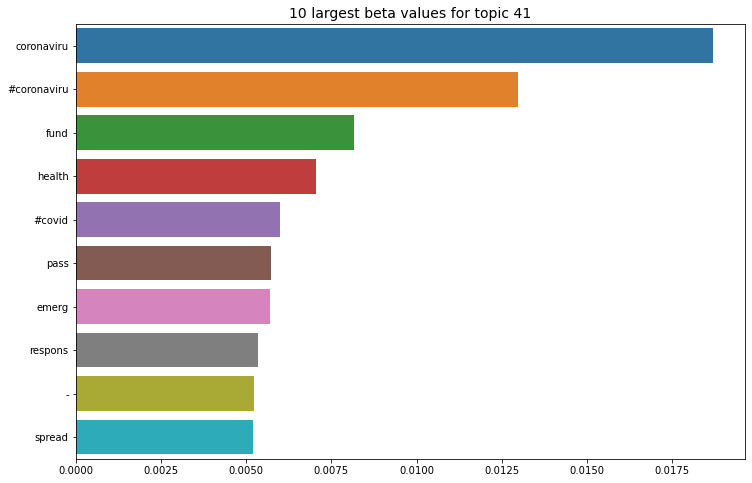

In [26]:
#Visualizing topic 41

#beta_df.iloc[41].nlargest(10) locates the 10 largest values in row 41. 
# .values returns the beta values
# .index returns the words

plt.figure(figsize = (12,8))

ax = sns.barplot(x = beta_df.iloc[41].nlargest(10).values, 
                 y = beta_df.iloc[41].nlargest(10).index, 
                 orient = 'h')

plt.title('10 largest beta values for topic 41', fontsize = 14)
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0, flags=flags)
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0, flags=flags)


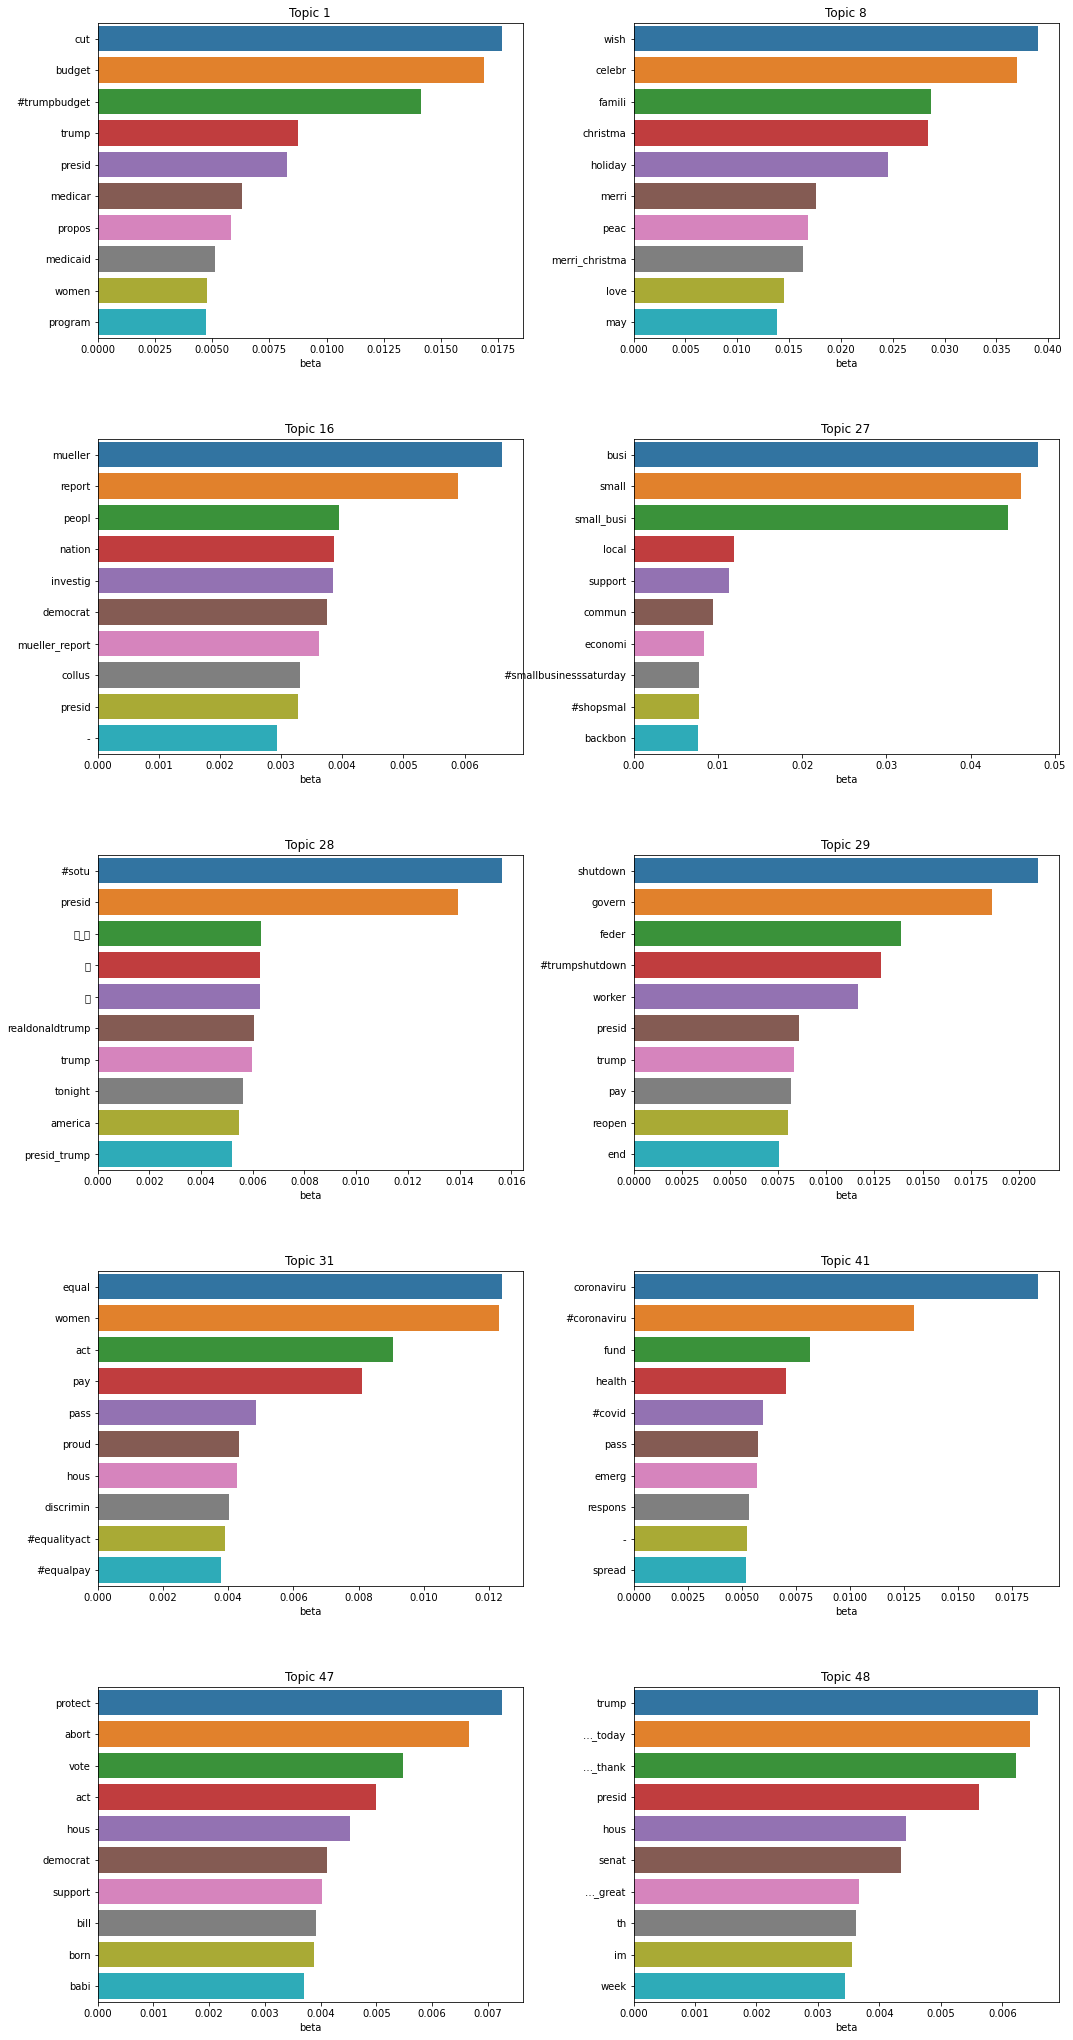

In [27]:
#Picking 10 topics to visualize
topics = [1, 8, 16, 27, 28, 29, 31, 41, 47, 48]

fig, axes = plt.subplots(ncols=2, nrows=5, figsize = (16,30)) #Setting 10 subplots and determining figure size
fig.tight_layout(pad=8.0) #This ensure space between the subplots so the text can more easily be read
    
for ax, topic in zip(axes.flatten(), topics): #Iterates through the axes and the topics
    
    #Creates 10 barplots with x as the beta values and y as the words
    sns.barplot(ax = ax, 
                x = beta_df.iloc[topic].nlargest(10).values, 
                y = beta_df.iloc[topic].nlargest(10).index, 
                orient = 'h')
    
    ax.set(title='Topic {}'.format(topic), xlabel='beta')

plt.show()

#Warnings are because matplotlib and seaborn can't interpret emojis correctly


### 4.2: Investigating results: gamma parameters

Retrieve the estimated **gamma parameters** from the model. For each document, you will get a list of topics with an associated gamma. The gammas indicate the probability (or amount) that a document is about a specific topic.

1. Use `get_document_topics` with the full corpus to get lists of probabilities for each document.
2. Save the probabilities in the original dataframe. You can find inspiration for how to do this in the pseudo-code:

**Pseudo-code to save the probabilities in the original dataframe:**

Use list comprehension to create a list of 50 topic names (e.g. topic_1, topic_2 etc.)

Create a dataframe filled with zeros of the shape (number of documents - 864, number of topics - 50) and with columns = the list of 50 topic names. 

For each index, document in the list of gamma probabilities: <br>
<font color=white>0000</font>for each topic-probability pair in the document: <br>
<font color=white>00000000</font>locate index and column with that topic name and save the probability

Concatenate this dataframe with the original dataframe over axis 1.



In [28]:
#Insert the corpus of documents in bag of word format and get a list of (topic, probability) per document. 

document_topics = list(lda_model.get_document_topics(corpus)) 


In [40]:
#Uncomment to view the document topics

#document_topics

In [30]:
#Creating a list of names for all 50 topics
topics = ['topic_{}'.format(t) for t in range(0,50)]

#Creating a dataframe of gamma probabilities 
gamma_probs = pd.DataFrame(np.zeros((len(document_topics),50)), columns = topics)

for i, doc in enumerate(document_topics): 
    for pair in doc: 
        gamma_probs.loc[i,'topic_{}'.format(pair[0])] = pair[1]


In [31]:
#Merging with the original dataframe 
gamma_df = pd.concat((tweets_agg,gamma_probs), axis = 1)

#Viewing the concatenated dataframe
gamma_df.head()

,date,affiliation,text,text_lemma,text_stemmed,unigrams,bigrams,tokens,topic_0,topic_1,...,topic_40,topic_41,topic_42,topic_43,topic_44,topic_45,topic_46,topic_47,topic_48,topic_49
0,2019-01-01,Democrat,"Out of a tragedy, some great news: with the Pr...",tragedy great news president signature tonight...,tragedi great news presid signatur tonight #as...,"[tragedi, great, news, presid, signatur, tonig...","[tragedi_great, great_news, news_presid, presi...","[tragedi, great, news, presid, signatur, tonig...",0.000004,0.000004,...,0.000004,0.000004,0.000004,0.000004,0.116614,0.000004,0.000004,0.000004,0.000004,0.000004
1,2019-01-01,Republican,"Have a happy, healthy and prosperous 2019! #H...",happy healthy prosperous #happynewyear # k #ne...,happi healthi prosper #happynewyear # k #newye...,"[happi, healthi, prosper, #happynewyear, #, k,...","[happi_healthi, healthi_prosper, prosper_#happ...","[happi, healthi, prosper, #happynewyear, #, k,...",0.000010,0.000010,...,0.000010,0.000010,0.000010,0.000010,0.207758,0.000010,0.000010,0.000010,0.000010,0.000010
2,2019-01-02,Democrat,Amen. https://t.co/fiM7C8e4lc “My supervisor t...,amen supervisor tell wont get pay bill wont ge...,amen supervisor told wont get paid bill wont g...,"[amen, supervisor, told, wont, get, paid, bill...","[amen_supervisor, supervisor_told, told_wont, ...","[amen, supervisor, told, wont, get, paid, bill...",0.000002,0.000002,...,0.000002,0.000002,0.000002,0.000002,0.001989,0.000002,0.000002,0.000002,0.000002,0.000002
3,2019-01-02,Republican,RT @cdw: I see that Mr. Alright Alright Alrigh...,see mr alright alright alright sideline #hooke...,see mr alright alright alright sidelin #hookem...,"[see, mr, alright, alright, alright, sidelin, ...","[see_mr, mr_alright, alright_alright, alright_...","[see, mr, alright, alright, alright, sidelin, ...",0.000005,0.000005,...,0.000005,0.000005,0.000005,0.000005,0.003443,0.000005,0.000005,0.000005,0.000005,0.558798
4,2019-01-03,Democrat,"Before the shutdown, before the pay freeze, th...",shutdown pay freeze federal government suffer ...,shutdown pay freez feder govern suffer lack le...,"[shutdown, pay, freez, feder, govern, suffer, ...","[shutdown_pay, pay_freez, freez_feder, feder_g...","[shutdown, pay, freez, feder, govern, suffer, ...",0.000000,0.000000,...,0.162080,0.000000,0.000000,0.000000,0.000888,0.000000,0.000000,0.000000,0.000000,0.000000


### 5: Visualizing the development of the coronavirus related topic 

Getting back to the original question: How has the topic of coronavirus progressed on Twitter among Members of Congress over time? 

1. Use `print_topics` to look through the 10 most relevant words of each topic and identify the topic related to coronavirus. 
2. If it is not already, convert the date column from string type to datetime type
3. Graph the development of the coronavirus topic over time. Create a plot where x = date, y = the covid topic, and hue = affiliation. 
4. Do the same with a subset of the dataset only including 2020. 

Can you see which party was quicker to set the agenda around COVID-19? 


In [32]:
#Using regex to find all words and filter them from the weights
words = [re.findall(r'"([^"]*)"',t[1]) for t in lda_model.print_topics(50,10)]

# Printing the topics in a nice format
for id, t in enumerate(words): 
    print(f"------ Topic {id} ------")
    print(' '.join(t), end="\n\n")
    
#Topic 41 is coronavirus


------ Topic 0 ------
internet_open introduc_war intermediate-rang_nuclear intern_agreement internet_continu internet_free interest_attend intimid_us invit_help invest_act

------ Topic 1 ------
cut budget #trumpbudget trump presid medicar propos medicaid women program

------ Topic 2 ------
trump protect im need famili health commun vote act hous

------ Topic 3 ------
border secur democrat job nation govern - congress presid continu

------ Topic 4 ------
hous trump presid fight need women vote protect support act

------ Topic 5 ------
labor worker #laborday labor_day #dorian famili day union right wage

------ Topic 6 ------
new tax new_year job happi_new famili peopl wage first -

------ Topic 7 ------
vote war right act iran congress hous pass trump must

------ Topic 8 ------
wish celebr famili christma holiday merri peac merri_christma love may

------ Topic 9 ------
constitut happi lewandowski birthday nd usairforc nd_birthday happi_nd document air

------ Topic 10 ------
impe

In [33]:
#Converting date from str type to datetime type
gamma_df['date'] = pd.to_datetime(gamma_df['date'])

In [38]:
#Uncomment to see all probabilities for the covid topic 

#for prob in gamma_df['topic_41']:
#    print(prob)

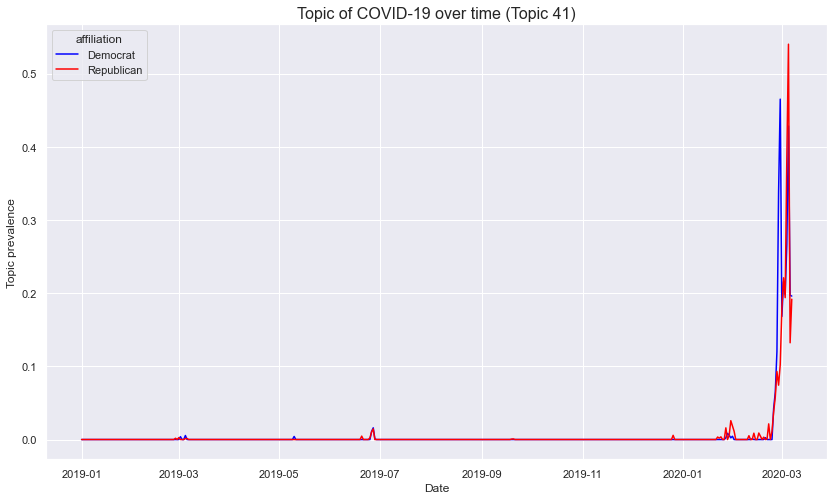

In [35]:
#Setting a theme
sns.set_theme(style="darkgrid")

#Plotting a figure and setting figure size
plt.figure(figsize = (14,8))

#Choosing colors
palette = ['blue','red'] 

#Plotting the covid topic for the full dataset
sns.lineplot(x = 'date', y = 'topic_41', hue = 'affiliation', data = gamma_df, palette = palette)

plt.title('Topic of COVID-19 over time (Topic 41)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

plt.show()

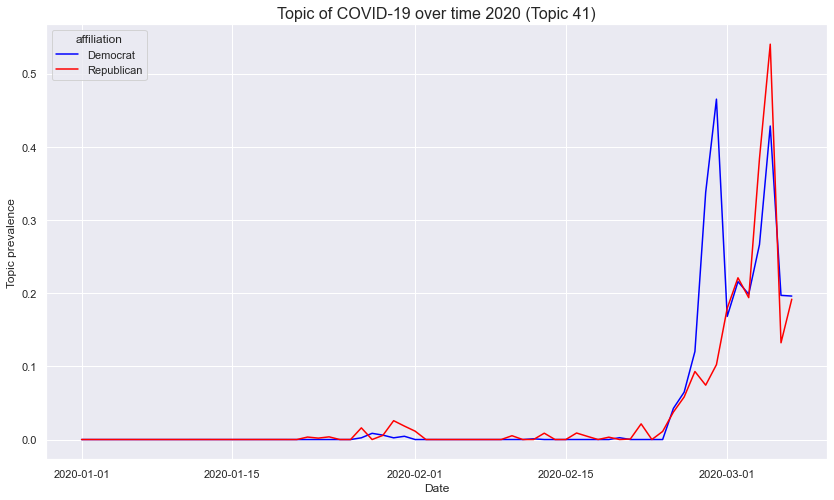

In [36]:
#Plotting the development of the covid topic for a 2020 subset of the dataset 

plt.figure(figsize = (14,8))
palette = ['blue','red']

sns.lineplot(x = 'date', y = 'topic_41', hue = 'affiliation', data = gamma_df.loc[gamma_df.date > datetime(2019,12,31)], palette = palette)

plt.title('Topic of COVID-19 over time 2020 (Topic 41)', fontsize = 16)
plt.ylabel('Topic prevalence')
plt.xlabel('Date')

plt.savefig('corona_topic_over_time2020_100topics_2.jpg')
plt.show()